## Set random seed to produce same results in every run

In [50]:
from numpy.random import seed
seed(111)
import tensorflow as tf
tf.random.set_seed(111)

## Determine the evaluation metrics

In [51]:
from tensorflow.keras import metrics
METRICS = [metrics.BinaryAccuracy(),
        metrics.Precision(name='precision'), 
        metrics.Recall(name='recall')]

## Load dataset

In [52]:
import pandas as pd
df = pd.read_csv("dataset_binary.csv")
df.head()

,Review,Rating
0,it`s the place i want to like. it`s local to m...,0
1,"For the youngsters of the world, funky, fast a...",0
2,We admittedly had inflated expectations of thi...,0
3,This was our second trip to Kiss Kiss with the...,0
4,The food was not bad... but nothing spectacula...,0


## Dataset includes 500 positive and 500 negative reviews.

In [53]:
df["Rating"].value_counts()

0    500
1    500
Name: Rating, dtype: int64

## Preprocessing

* Remove everything except letters
* Convert to lowercase
* Stemming

In [54]:
import nltk
nltk.download('stopwords') # download stopwords

import re
import numpy as np

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()
stopwords_english = stopwords.words('english')
corpus = []

for x in range(0, df.shape[0]):
    review = re.sub('[^a-zA-Z]', ' ', df["Review"][x]) # remove everything except letters
    review = review.lower() # convert everthing to lowercase
    review = review.split() #split a review into a list
    review = [stemmer.stem(i) for i in review if i not in set(stopwords_english)] #stemming and deleting stopwords
    review = ' '.join(review) #Join all items in a list into a string
    corpus.append(review) #add review to corpus list


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yasem\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Below is the preprocessed tweets

In [55]:
corpus[:5]

['place want like local serv booz menu interest idea food terribl order one two noodl dish food arriv waiter call anoth name cook serv mani year hot ugli kitchen everyon know would chuck bottom bag broken noodl bit away kiss kiss bowl full broken inch piec noodl mayb two inch longest guy realli care much custom work chef learn art prison none guy would stoop low boil broken bottom bag bit pay custom partner salad ok soggi could prepar dress earlier stage salad tast ok',
 'youngster world funki fast vogu good select thai fusion lack embed asian flavour view quit pricey well great staff though enjoy',
 'admittedli inflat expect place came highli recommend friend quit expect still tri figur quit thought admittedli probabl outsid usual demograph probabl',
 'second trip kiss kiss group friend order almost dish last time howev qualiti food great rib dri chicken cook would think',
 'food bad noth spectacular servic good friendli staff realli want get rich excit flavour dozen eateri situat nex

## Split train and test set: %80 Train, %20 Test

In [56]:
y = df.iloc[:,1].values # labels
X = corpus # reviews
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0, stratify=y)

In [57]:
print("X_train len: ", len(X_train))
print("y_train len: ", len(y_train))
print("X_test len: ", len(X_test))
print("y_test len: ", len(y_test))

X_train len:  800
y_train len:  800
X_test len:  200
y_test len:  200


## From sentences to word embeddings

In [58]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_words = 2500 # maximum words in the vocabulary
max_len = 200 # maximum sequence length

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
training_sequences = tokenizer.texts_to_sequences(X_train) # create sequences of tokens representing each sentence
training_padded = pad_sequences(training_sequences, maxlen=max_len, truncating="post")
print("training sequences:\n",training_padded)

testing_sequences = tokenizer.texts_to_sequences(X_test) # create sequences of tokens representing each sentence
testing_padded = pad_sequences(testing_sequences, maxlen=max_len, truncating="post")
print("testing sequences:\n",testing_padded)

X_train = training_padded
X_test = testing_padded

training sequences:
 [[   0    0    0 ...  308    8   20]
 [   0    0    0 ...  151  734   41]
 [   0    0    0 ...  735   67   20]
 ...
 [   0    0    0 ...  836   60 2382]
 [   0    0    0 ...   43   26   13]
 [   0    0    0 ...  551  435   13]]
testing sequences:
 [[   0    0    0 ...   98 1378  128]
 [   0    0    0 ...   18   49   12]
 [   0    0    0 ...   19 1085   45]
 ...
 [   0    0    0 ...    3  225  210]
 [   0    0    0 ...  254  842  228]
 [   0    0    0 ...   82   66  127]]


In [59]:
#tokenizer.word_index # indexed stems/words starting with the most frequent stem/word
#tokenizer.word_counts # number of apperences of every stem in train dataset

## Confusion matrix visualization

In [60]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# source: https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
def print_confusion_matrix(cf_matrix):
    df_cm = pd.DataFrame(cf_matrix, columns=np.unique([0,1]), index = np.unique([0,1]))
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    group_names = ["True Neg","False Pos", "False Neg", "True Pos"]
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(df_cm, annot=labels, fmt="", cmap='Blues')

In [61]:
from keras.models import Sequential
from keras import layers
from keras.callbacks import ModelCheckpoint
import tensorflow as tf

## Train with LSTM

In [62]:
def lstm_model():
    model = Sequential()
    model.add(layers.Embedding(max_words, 45, input_length=max_len)) #The embedding layer

    model.add(layers.LSTM(256, return_sequences=True))
    model.add(layers.LSTM(216, return_sequences=True))
    model.add(layers.LSTM(152))
  
    model.add(layers.Dense(488, activation="relu"))

    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer="rmsprop",loss='binary_crossentropy', metrics=METRICS)
    model.summary()

    return model


In [63]:
model1 = lstm_model()
callback1 = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=3)
checkpoint1 = ModelCheckpoint("best_model1.hdf5", monitor='val_binary_accuracy', verbose=1,save_best_only=True, mode='auto',save_weights_only=False)
history1 = model1.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[checkpoint1, callback1], batch_size=64)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 200, 45)           112500    
_________________________________________________________________
lstm_9 (LSTM)                (None, 200, 256)          309248    
_________________________________________________________________
lstm_10 (LSTM)               (None, 200, 216)          408672    
_________________________________________________________________
lstm_11 (LSTM)               (None, 152)               224352    
_________________________________________________________________
dense_4 (Dense)              (None, 488)               74664     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 489       
Total params: 1,129,925
Trainable params: 1,129,925
Non-trainable params: 0
____________________________________________

## Test trained LSTM model on test data

In [64]:
# Evaluate the model on the test data
print("Evaluate on test data")
results1 = model1.evaluate(X_test, y_test, batch_size=64)
print("test loss, test acc, test precion, test recall:", results1)

Evaluate on test data
4/4 [==============================] - 2s 538ms/step - loss: 0.6023 - binary_accuracy: 0.7950 - precision: 0.7323 - recall: 0.9300
test loss, test acc, test precion, test recall: [0.6022944450378418, 0.7950000166893005, 0.7322834730148315, 0.9300000071525574]


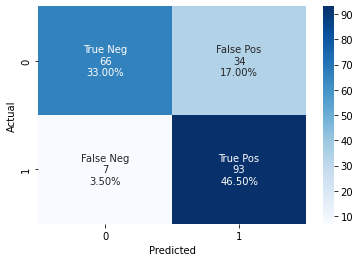

In [65]:
# Generate predictions/probabilities (the output of the last layer)
predictions = model1.predict(X_test)

# to create confusion matrix transform probabilities to labels (if predicted more than 0.5 positivie-1 else negative-0 ))
y_pred = []
for i, predicted in enumerate(predictions):
    if predicted[0] >= 0.5:
        y_pred.append(1)
        #assign i to class 1
    else:
         y_pred.append(0)
        #assign i to class 0

# list to numpy array
y_pred = np.array(y_pred)

c = confusion_matrix(y_test, y_pred) # create confusion matrix
print_confusion_matrix(c) # print confusion matrix

## Train with Bidirectional LSTM

In [66]:
def bilstm_model():
    model = Sequential()
    model.add(layers.Embedding(max_words, 45, input_length=max_len))
    model.add(layers.Bidirectional(layers.LSTM(24,dropout=0.3, return_sequences=True)))
    model.add(layers.Bidirectional(layers.LSTM(136,dropout=0.9, return_sequences=True)))
    model.add(layers.Bidirectional(layers.LSTM(232)))
    model.add(layers.Dense(1,activation='sigmoid'))

    model.compile(optimizer='adam',loss='binary_crossentropy', metrics=METRICS)
    model.summary()
    return model

In [67]:
model2 = bilstm_model()
callback2 = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=3)
checkpoint2 = ModelCheckpoint("best_model2.hdf5", monitor='val_binary_accuracy', verbose=1,save_best_only=True, mode='auto', save_weights_only=False)
history2 = model2.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[checkpoint2, callback2],batch_size=64)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 200, 45)           112500    
_________________________________________________________________
bidirectional_6 (Bidirection (None, 200, 48)           13440     
_________________________________________________________________
bidirectional_7 (Bidirection (None, 200, 272)          201280    
_________________________________________________________________
bidirectional_8 (Bidirection (None, 464)               937280    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 465       
Total params: 1,264,965
Trainable params: 1,264,965
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
10/10 [==============================] - 52s 5s/step - loss: 0.6898 - binary_accuracy: 0.6012 - pr

## Test trained Bidirectional LSTM model on test data

In [71]:
# Evaluate the model on the test data
print("Evaluate on test data")
results2 = model2.evaluate(X_test, y_test, batch_size=64)
print("test loss, test acc, test precion, test recall:", results2)

Evaluate on test data
4/4 [==============================] - 3s 638ms/step - loss: 0.5785 - binary_accuracy: 0.8300 - precision: 0.8367 - recall: 0.8200
test loss, test acc, test precion, test recall: [0.5784773826599121, 0.8299999833106995, 0.8367347121238708, 0.8199999928474426]


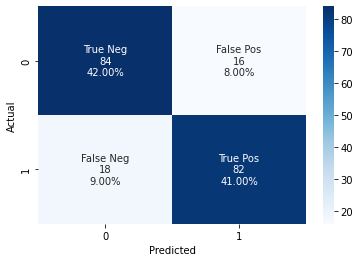

In [72]:
# Generate predictions/probabilities (the output of the last layer)
predictions = model2.predict(X_test)

# to create confusion matrix transform probabilities to labels (if predicted more than 0.5 positivie-1 else negative-0 ))
y_pred = []
for i, predicted in enumerate(predictions):
    if predicted[0] >= 0.5:
        y_pred.append(1)
        #assign i to class 1
    else:
         y_pred.append(0)
        #assign i to class 0

#list to numpy array
y_pred = np.array(y_pred)

c = confusion_matrix(y_test, y_pred) # create confusion matrix
print_confusion_matrix(c) # print the confusion matrix

## Train with CNN

In [73]:
def cnn_model():
    model = Sequential()
    model.add(layers.Embedding(max_words, 35, input_length=max_len))

    model.add(layers.Conv1D(38, 2, activation='relu'))
    model.add(layers.Conv1D(26, 8, activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(1,activation='sigmoid'))

    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=METRICS)
    model.summary()

    return model

In [74]:
model3 = cnn_model()
callback3 = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=3)
checkpoint3 = ModelCheckpoint("best_model3.hdf5", monitor='val_binary_accuracy', verbose=1,save_best_only=True, mode='auto', save_weights_only=False)
history3 = model3.fit(X_train, y_train, epochs=70, validation_split=0.2, callbacks=[checkpoint3, callback3])

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 200, 35)           87500     
_________________________________________________________________
conv1d (Conv1D)              (None, 199, 38)           2698      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 192, 26)           7930      
_________________________________________________________________
flatten (Flatten)            (None, 4992)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 4993      
Total params: 103,121
Trainable params: 103,121
Non-trainable params: 0
_________________________________________________________________
Epoch 1/70
20/20 [==============================] - 1s 32ms/step - loss: 0.6937 - binary_accuracy: 0.5786 - precis

## Test trained CNN model on test data

In [75]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results3 = model3.evaluate(X_test, y_test, batch_size=64)
print("test loss, test acc, test precion, test recall:", results3)

Evaluate on test data
4/4 [==============================] - 0s 6ms/step - loss: 0.6170 - binary_accuracy: 0.8350 - precision: 0.8018 - recall: 0.8900
test loss, test acc, test precion, test recall: [0.6170077323913574, 0.8349999785423279, 0.8018018007278442, 0.8899999856948853]


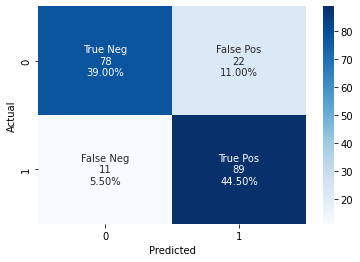

In [76]:
predictions = model3.predict(X_test)

y_pred = []
for i, predicted in enumerate(predictions):
    if predicted[0] >= 0.5:
        y_pred.append(1)
        #assign i to class 1
    else:
         y_pred.append(0)
        #assign i to class 0

y_pred = np.array(y_pred)

c = confusion_matrix(y_test, y_pred)
print_confusion_matrix(c)